In [1]:
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.models import UnivNetModel
from nemo.collections.tts.models import FastPitchModel
from nemo.collections.asr.parts.preprocessing.features import WaveformFeaturizer
import json
import torch
import os
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

[NeMo W 2022-07-26 15:59:00 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-07-26 15:59:00 experimental:27] Module <class 'nemo.collections.tts.torch.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
def sync(wave_model, spec_gen_model, vocoder_model, audio_path):
    
    features = wave_model.process(audio_path, trim=False)
    audio, audio_length = features, torch.tensor(features.shape[0]).long()
    audio = audio.unsqueeze(0).to(device=spec_gen_model.device)
    audio_length = audio_length.unsqueeze(0).to(device=spec_gen_model.device)
    with torch.no_grad():
        spectrogram, spec_len = spec_gen_model.preprocessor(input_signal=audio, length=audio_length)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio


In [3]:
def infer(spec_gen_model, vocoder_model, str_input, speaker=None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Args:
        spec_gen_model: Spectrogram generator model (FastPitch in our case)
        vocoder_model: Vocoder model (HiFiGAN in our case)
        str_input: Text input for the synthesis
        speaker: Speaker ID
    
    Returns:
        spectrogram and waveform of the synthesized audio.
    """
    with torch.no_grad():
        parsed = spec_gen_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().to(device=spec_gen_model.device)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

In [5]:
sample_rate = 22050

# best_ckpt = '/home/chsieh/chengping-ws/fastpitch/completed/emb-all/FastPitch/2022-07-08_07-44-15/checkpoints/FastPitch--v_loss=0.8746-epoch=199.ckpt'
best_ckpt = '/home/chsieh/chengping-ws/fastpitch/completed/emb-all-add-cln/FastPitch/2022-07-13_21-39-05/checkpoints/FastPitch--v_loss=0.8200-epoch=479.ckpt'
spec_model = FastPitchModel.load_from_checkpoint(best_ckpt)
spec_model.eval().cuda()

# vocoder_model = HifiGanModel.from_pretrained("tts_hifigan")
# vocoder_model = UnivNetModel.from_pretrained("tts_en_libritts_univnet")
best_ckpt = '/home/chsieh/chengping-ws/hifigan/inprogress/3149645_/HifiGan/2022-07-20_03-24-30/checkpoints/HifiGan--val_loss=0.4667-epoch=1499.ckpt'
vocoder_model = HifiGanModel.load_from_checkpoint(checkpoint_path=best_ckpt)
vocoder_model = vocoder_model.eval().cuda()

wave_model = WaveformFeaturizer(sample_rate=sample_rate)

[NeMo I 2022-07-26 15:59:50 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-07-26 16:00:15 experimental:27] Module <class 'nemo.collections.tts.torch.g2ps.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-07-26 16:00:16 g2ps:86] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-07-26 16:00:16 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/mtts-dataset/train-100.json
      sample_rate: 22050
      sup_data_path: /raid/speech_sup/fastpitch_sup_data_folder
      sup_data_types:
      - align_prior_matrix
  

[NeMo I 2022-07-26 16:00:16 features:200] PADDING: 1


[NeMo W 2022-07-26 16:00:21 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: /ws/mel-dataset/Libritts-FP-embadd-cln-mels-22k/hifigan_train.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
      pin_memory: true
    
[NeMo W 2022-07-26 16:00:21 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.co

[NeMo I 2022-07-26 16:00:21 features:200] PADDING: 0
[NeMo I 2022-07-26 16:00:21 features:208] STFT using exact pad
[NeMo I 2022-07-26 16:00:21 features:200] PADDING: 0
[NeMo I 2022-07-26 16:00:21 features:208] STFT using exact pad


In [6]:
num_val = 5  # Number of validation samples
val_records = []
with open(f"/home/chsieh/manifest/mtts-dataset/val-100.json", "r") as f:
    for i, line in enumerate(f):
        val_records.append(json.loads(line))
        if len(val_records) >= num_val:
            break

In [7]:
save_audio_path = os.path.join("/home/chsieh/results", "pt-emb-all-add-cln")
os.makedirs(save_audio_path, exist_ok=True)

Speaker: 8194 | Text: His heavy face lit up with a gleam of malicious satisfaction as Diana came towards him, his loose mouth broadened in a wicked smile.
Real validation audio


Sync validation audio


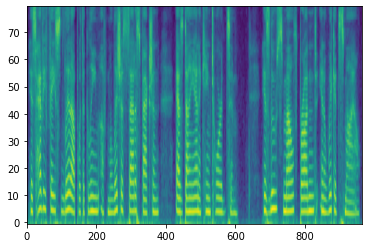

Gen validation audio


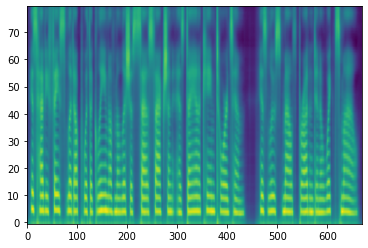

Speaker: 7314 | Text: However, I guess he will say something about it when he gets ready."
Real validation audio


Sync validation audio


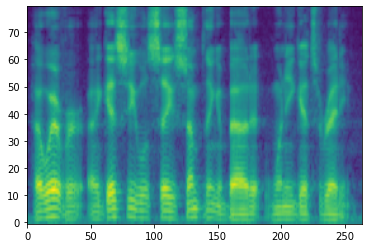

Gen validation audio


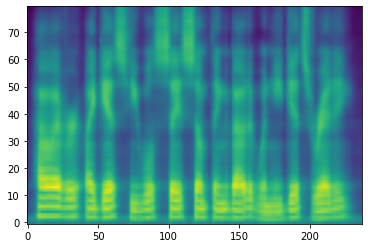

Speaker: 8152 | Text: It is none too many, as every reason for the modern, as contrasted with the primitive, organization of industry should be included.
Real validation audio


Sync validation audio


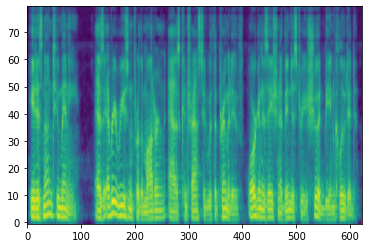

Gen validation audio


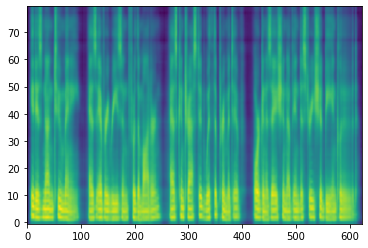

Speaker: 6189 | Text: Not at all! He proposes a job to me, and offers to pay me.
Real validation audio


Sync validation audio


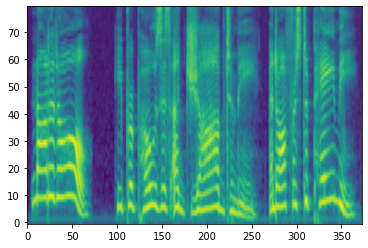

Gen validation audio


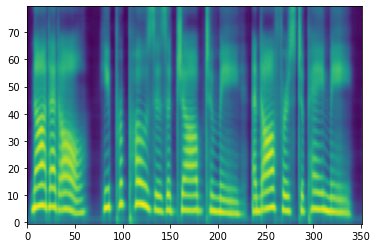

Speaker: 7145 | Text: She looked at him for a brief space with softening eyes, and, lifting her hand, put it back in his, saying:
Real validation audio


Sync validation audio


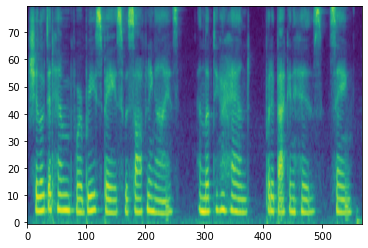

Gen validation audio


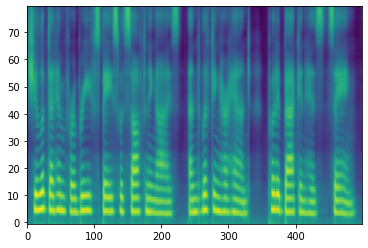

In [8]:
%matplotlib inline

for val_record in val_records:
    print(f"Speaker: {val_record['old_speaker_id']} | Text: {val_record['text']}")
    
    save_audio_path_user = os.path.join(save_audio_path, str(val_record['old_speaker_id']))
    os.makedirs(save_audio_path_user, exist_ok=True)
    with open(os.path.join(save_audio_path_user, 'text.txt'), 'w') as f: f.write(val_record['text'])
    
    print("Real validation audio")
    audio = ipd.Audio(val_record['audio_filepath'], rate=sample_rate)
    with open(os.path.join(save_audio_path_user, 'real.wav'), 'wb') as f: f.write(audio.data)
    ipd.display(audio)
    
    print("Sync validation audio")
    spec,audio = sync(wave_model, spec_model, vocoder_model, audio_path=val_record['audio_filepath'])
    audio = ipd.Audio(audio, rate=sample_rate)
    with open(os.path.join(save_audio_path_user, 'sync.wav'), 'wb') as f: f.write(audio.data)
    ipd.display(audio)
    
    plt.imshow(spec, origin="lower", aspect="auto")
    plt.savefig(os.path.join(save_audio_path_user, 'sync-spec.png'))
    plt.show()
    
    
    print("Gen validation audio")
    spec, audio = infer(spec_model, vocoder_model, val_record['text'], speaker=val_record['speaker'])
    audio = ipd.Audio(audio, rate=sample_rate)
    with open(os.path.join(save_audio_path_user, 'gen.wav'), 'wb') as f: f.write(audio.data)
    ipd.display(audio)

    plt.imshow(spec, origin="lower", aspect="auto")
    plt.savefig(os.path.join(save_audio_path_user, 'gen-spec.png'))
    plt.show()